# 07.01 Regularization and Linear Regression

Regression is different from classification in that it tries to predict continuous values.
In other words, we are predicting a value instead of classes or labels.
Regression is somewhat older then classification, and stems from experimental science,
which collected data in the attempt to find mathematical representations
(functions) of natural phenomena.
During that period regression was (and often still is) called *function approximation*.
The simplest form of regression is the *least squares* technique.

Let's say that we performed an collected experimental data.
This data is likely to be an insight into a process about which we want to learn.
Yet, the data is incomplete and ridden with experimental error,
making it hard to recreate the process that was measured.
In the simplest case we'd like to find a line $y = w_1x + w_0$ which
*we assume* would be a good approximation of the process.

Note: There are several notations used for linear regression or function approximation.
Some literature will draw the line equation as $f(x) = ax + b$, others as $y = a_0 + a_1x$,
or a combination of these notations.
In Machine Learning most people prefer to use $w$ to denote the parameters,
a mnemonic to *weight*.  In this notation we write the line equation as $y = w_1x + w_0$.

`sklearn`'s `LinearRegression`, by default, performs a least squares approximation.

![Car Driving](reg-driver.svg)

<div style="text-align:right;"><sup>reg-driver.svg</sup></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.linear_model import LinearRegression

## Road Trip

As a simple example we can **estimate the mean speed** on a road curve by **measuring
the position** of every car starting from the entry into the curve $(t = 0)$.
Let's say we got the following measures.

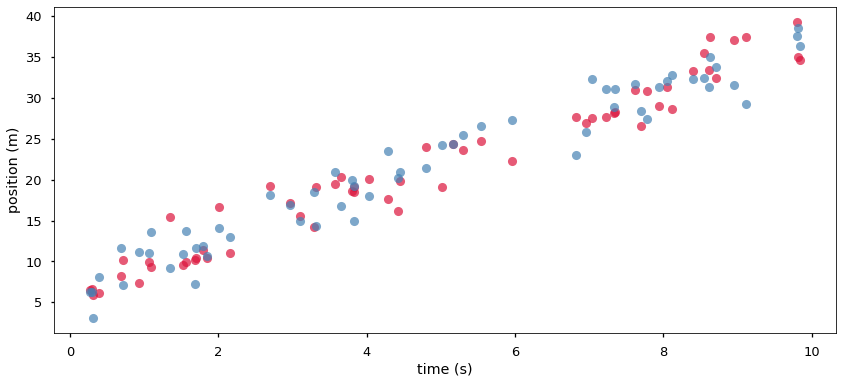

In [2]:
t = 10*np.random.rand(60)
pos1 = 7 + t*3 + 2*np.random.randn(*t.shape)
pos2 = 7 + t*3 + 2*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(t, pos1, 'o', color='crimson', alpha=0.7)
ax.plot(t, pos2, 'o', color='steelblue', alpha=0.7)
ax.set_xlabel('time (s)')
ax.set_ylabel('position (m)');

Least squares attempts to minimize the error (residual) across all points:
$$r = \sum_{i=1}^{N} (f(x_i) - y_i)^2 = \sum (f(\vec{X}) - \vec{y})^2$$

We can say that we are minimizing the error of the point to a function of the form:

$$y = w_1x + w_0$$

The minimization, in two dimensions, can be understood as (here $X$, $w$ and $y$ are vectors):

$$\min_{w} \|Xw - y\|$$

For the case of a line $y = w_1x + w_0$ we search for the parameters $w_0$ and $w_1$,
and these can be found analytically.
There are several ways of getting to these equations,
one of them is to walk the function formed by the residuals for all values of $w_0$ and $w_1$.
The surface of the parameters $w_0$ and $w_1$ is concave,
therefore exist a single point where the gradient is exactly zero.
Form this point we get.

$$
w_0 = \frac{\overline{y} \sum_{i=0}^{n} x_i^2 - \overline{x} \sum_{i=0}^{n} x_iy_i}
{\sum_{i=0}^{n} x_i^2 - n \overline{x}^2}\\
w_1 = \frac{\sum_{i=0}^{n} x_iy_i - n \overline{x} \overline{y}}
{\sum_{i=0}^{n} x_i^2 - n \overline{x}^2}
$$

In our case $a_1$ is the *mean speed* we are after.  `sklearn` will do the calculation for us.
The linear regression in `sklearn` produces the resulting parameters as `intercept_` containing $w_0$
and `coef_` containing $w_1, w_2, ...$ (for example, in the case where we have more dimensions).

array([3.0983753])

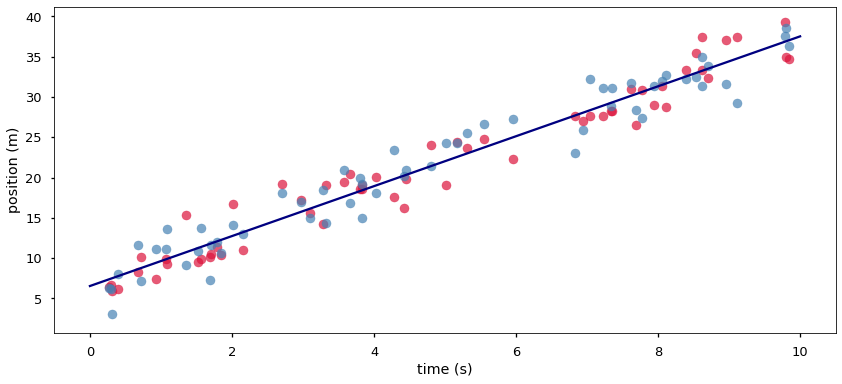

In [3]:
pos = np.hstack([pos1, pos2])
t_points = np.vstack([t[:, np.newaxis], t[:, np.newaxis]])
model = LinearRegression()
model.fit(t_points, pos)
xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(t, pos1, color='crimson', alpha=0.7)
ax.scatter(t, pos2, color='steelblue', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('position (m)')
model.coef_

Now we know how to **measure the mean speed** (assuming that we can compare positions very quickly).
But what if we want the **typical speed at each point** across more than just a single curve?
Let's generate some data that is akin of:

1.  Slowing down before turn.
2.  Gaining speed slowly in the turn.
3.  Gaining speed faster after exiting the curve.

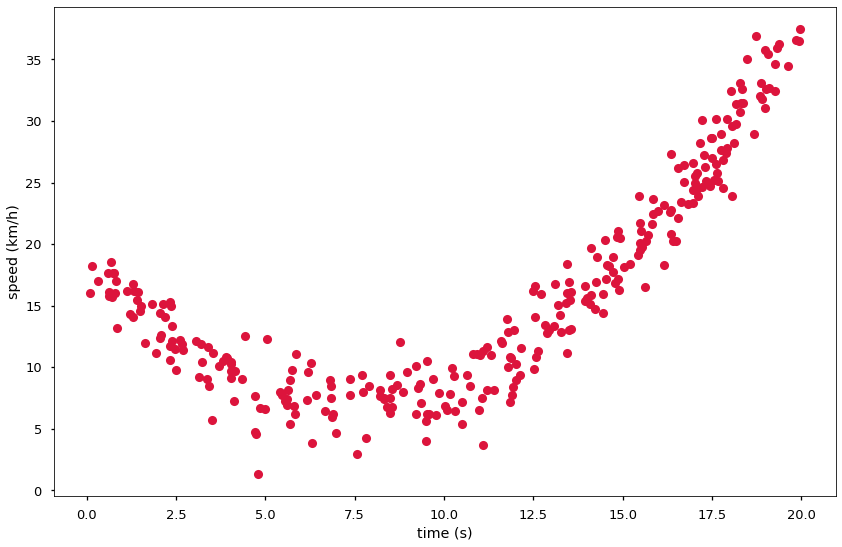

In [4]:
t = 20*np.random.rand(300)
spd = 7 + 0.2*(t-7.5)**2 + 2*np.random.randn(*t.shape)
#spd = 18 + -3*t + 0.2*t**2 + 2*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(t, spd, 'o', color='crimson')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)');

That kind of looks like a function akin of:

$$y = w_2x^2 + w_1x + w_0$$

The traditional (read: non-computational) method to solve this problem is to get rid of $x^2$
by applying a logarithmic transformation to the axes, and then apply the linear
regression as normal since the graph would be a line.  For example:

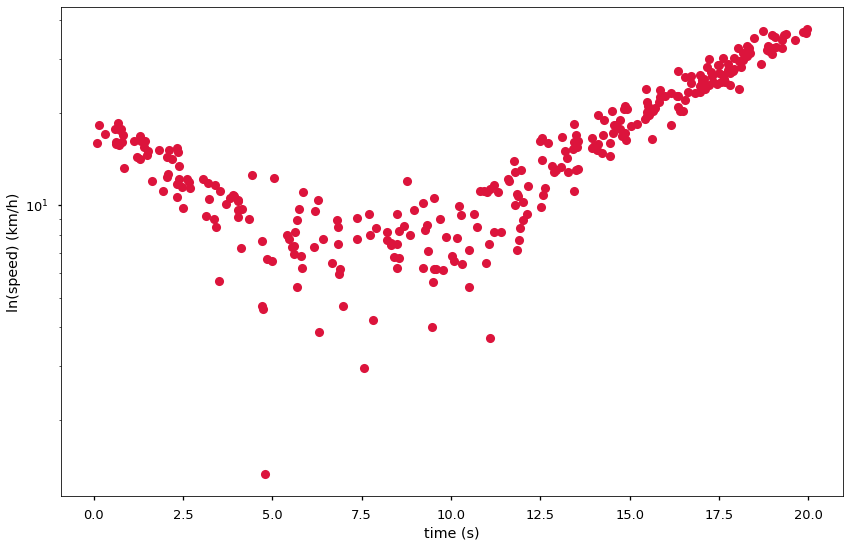

In [5]:
fig, ax = plt.subplots(figsize=(14, 9))
ax.semilogy(t, spd, 'o', color='crimson')
ax.set_xlabel('time (s)')
ax.set_ylabel('ln(speed) (km/h)');

We can now divide our data at, say, $t = 7.5$ and generate two linear regressions,
one for each side.  But there are better ways!

Since we can easily operate in more than two dimensions (time and speed in our case)
let's build this same model in three dimensions: time, speed *and speed squared*.
`sklearn` provides us with `PolynomialFeatures` preprocessor for such cases.

In more dimensions we will search for more coefficients.
The general least squares equation can compe with as many dimensions as we need:

$$\min_{w_1, \dots, w_{d - 1}} \|Xw_j - y\|$$

Which is analogous to:

$$f(x_0, x_1, \dots, x_i) = w_0 + w_1x_0 + w_2x_1\dots + w_ix_{i-1} + w_{i+1}x_i$$

Where a single coefficient is multiplies by each dimension (each axis).
But nothing prevents us from doing the following,
i.e. use the same dimension twice, with a tweak:

$$f(x) = w_0 + w_1x + w_2x^2$$

This is still a linear model since neither $w$ parameter multiplies each other.
`sklearn`'s `PolynomialFeatures` can transform the data for us
(instead of us doing it by hand).

In [6]:
from sklearn.preprocessing import PolynomialFeatures

pol = PolynomialFeatures(degree=2)
pol.fit_transform(spd[:, np.newaxis])[:10, :]

array([[  1.        ,  21.7105122 , 471.34633994],
       [  1.        ,  10.60337238, 112.43150581],
       [  1.        ,  17.16977729, 294.80125226],
       [  1.        ,  12.57241033, 158.06550139],
       [  1.        ,  27.812813  , 773.55256704],
       [  1.        ,   7.48869024,  56.08048157],
       [  1.        ,  13.19316409, 174.05957858],
       [  1.        ,  15.11055992, 228.32902104],
       [  1.        ,  16.01302939, 256.41711025],
       [  1.        ,  24.61305422, 605.80243825]])

That looks good, we have a matrix of parameters for $x^0, x^1 x^2$,
now we can fit a line to that and then multiply by these parameters
again when we `perdict` the result.
Remembering to multiply things back when predicting is something that `sklearn` can do for us.
We use a **pipeline** which joins one - or more - preprocessors with an estimator,
in this case we join the polynomial features with the linear regression.
This is what a Polynomial Regression is below the hood.

We now have one *hyperparameter* in our model, the degree of the polynomial.
That said, we are rather confident that we are after a 2nd degree polynomial,
therefore we probably know the best value for that hyperparameter.

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

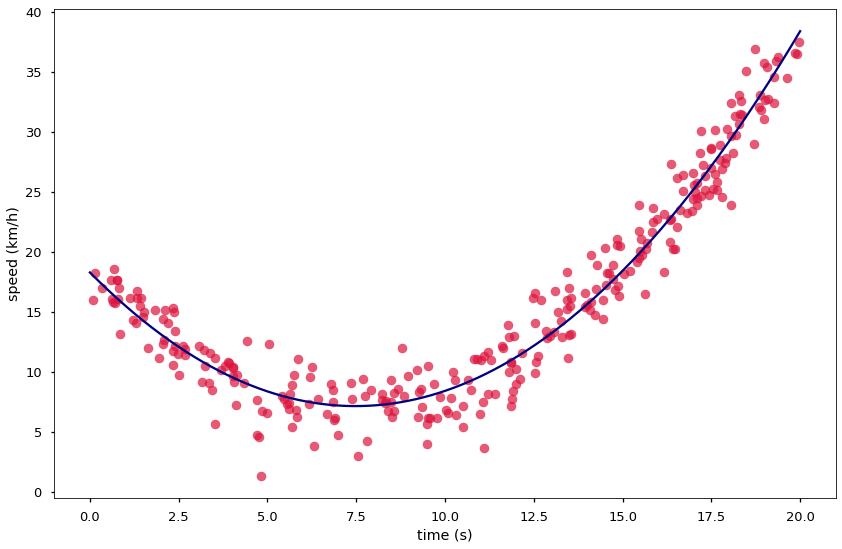

In [7]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 20, 2000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(14, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (km/h)')
model

In [8]:
model.named_steps.linearregression.intercept_, model.named_steps.linearregression.coef_

(array([18.28154233]), array([[ 0.        , -2.97904098,  0.19921521]]))

We are confident, by-eye, that our estimation is good.
Still, let's be careful and evaluate how our model performs on unknown data.

Each model type in `sklearn` contains a `.score` method,
which contains a scoring method appropriate for a common model of that type.
On classification models it will contain the mean accuracy or F1 score.
For the linear regression the scoring is the [Coefficient of Determination (R2)][r2score]:
the residual error after regression divided by the total regression error
(it is always between 0 and 1).

[r2score]: https://en.wikipedia.org/wiki/Coefficient_of_determination

In [9]:
from sklearn.model_selection import train_test_split

t1, t2, s1, s2 = train_test_split(t, spd, train_size=0.7, test_size=0.3)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(t1[:, np.newaxis], s1[:, np.newaxis])
model.score(t2[:, np.newaxis], s2[:, np.newaxis])

0.9464113212902151

## Cross Validation

As we saw before, the score varies depending on how the training and test sets are selected.
Therefore, in order to get a good sense on how the model performs,
we should repeat the train-test split and perform the scoring at each split.

Yet, `sklearn` has automated that for us  with `cross_val_score`, a way of splitting data
into training and test sets in several part and then scoring each pair.
This concept is called **cross-validation** and is prominent in all of machine learning.

In [10]:
from sklearn.model_selection import cross_val_score

model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
cross_val_score(model, t[:, np.newaxis], spd[:, np.newaxis], cv=5)

array([0.93522902, 0.95131929, 0.94811473, 0.94204072, 0.95038818])

Now we can reasonably say that we are confident in our model.
In other words, thanks to the cross-validation scores,
we are confident that our model can reasonably predict values for new input data.
In machine learning we often say that our model can **generalize** well
to previously unknown data.

## Full Road Trip

Let's move forward: can we estimate the speed at each point on a longer strip of a road?
For example, some 30km of a road with turns and inclines.

For our simulation it is interesting to note that most problems in the real world are not linear,
they are either exponential or periodic.  Why?  Something, something complexity theory.
Anyway, speed on a road is a periodic problem, one speeds up and down in response
to the shape of the road he drives on.

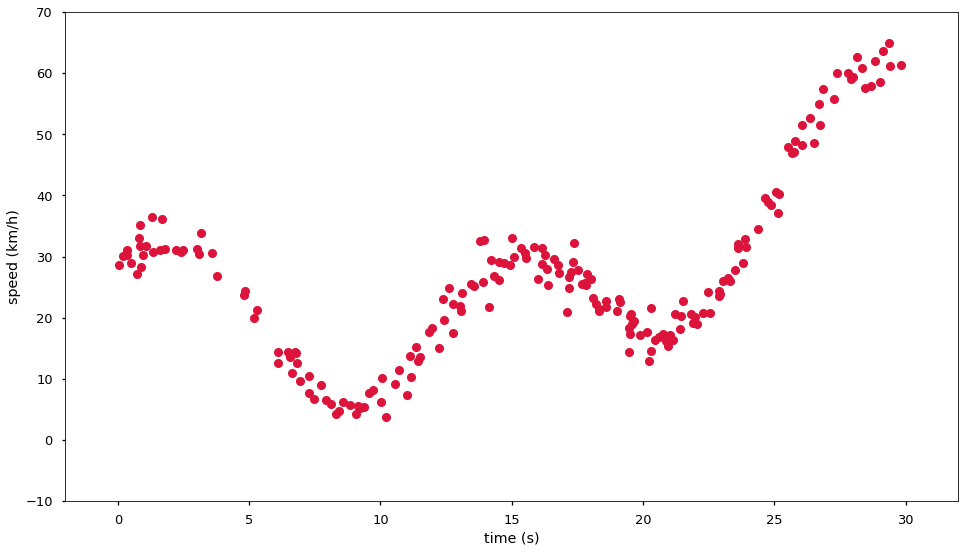

In [11]:
t = 30*np.random.rand(200)
spd = 13*np.sin(t/2) + 3.7*np.cos(t/2+7) + 3*t + 0.1*(t-10)**2 - 3*(t-3) + 7 + 2.3*np.random.randn(*t.shape)
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(t, spd, 'o', color='crimson')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70));

It is pretty difficult to figure out what polynomial degree we need for this fit.
But let's try a guess, degree 5:

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

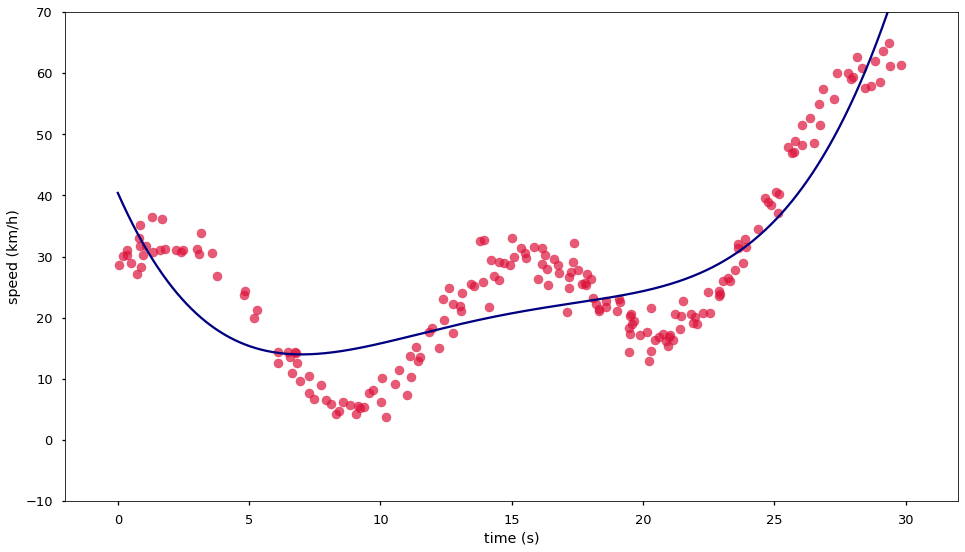

In [12]:
model = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70))
model

Ouch, that went pretty badly.  This is a case where out model **underfits** the data,
i.e. our model has not enough complexity to model the complexity we see.
We can also say that our model has too much **bias** about how the data looks.

Let us try with a big degree, e.g. 100.

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=100, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

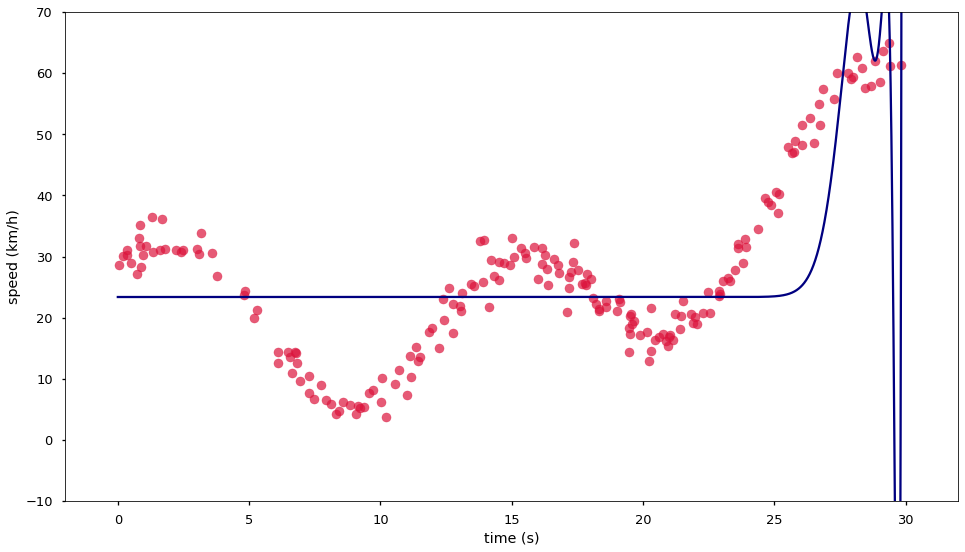

In [13]:
model = make_pipeline(PolynomialFeatures(degree=100), LinearRegression())
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70))
model

That ain't good either.
On the left hand side we passed the point where we can bend
the polynomial and our parameters mess with each other.
On the right hand side the polynomial **overfits** the data;
or we say that the model has too much **variance**.

There is more than one way to solve this problem.
Let's see a handful of possibilities.

## Bias versus Variance - Model Selection

To solve the right hand side problem we need to tune of *hyperparameter*,
the degree of our polynomial.
Until now we have been guessing and doing this by hand but trying all values between 5 and 100
by hand does not seem like a good way of spending an afternoon.
Instead `sklearn` can automate this for us.

We will train a model for every degree between 5 and 100 and evaluate,
by cross-validation, which model performs better.
`sklearn` provides us with a grid search algorithm,
which will perform the training and cross-validating of our model
for all hyperparameter values given to it.
This may already sort our problem.

(Pipeline(memory=None,
          steps=[('polynomialfeatures',
                  PolynomialFeatures(degree=10, include_bias=True,
                                     interaction_only=False, order='C')),
                 ('linearregression',
                  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                   normalize=False))],
          verbose=False),
 array([28.92283884]),
 array([[ 0.00000000e+00,  3.88186542e+00, -1.63023590e+00,
          6.44662834e-01, -2.54208482e-01,  4.69635308e-02,
         -4.45172979e-03,  2.35915638e-04, -7.10029520e-06,
          1.13724190e-07, -7.54325047e-10]]))

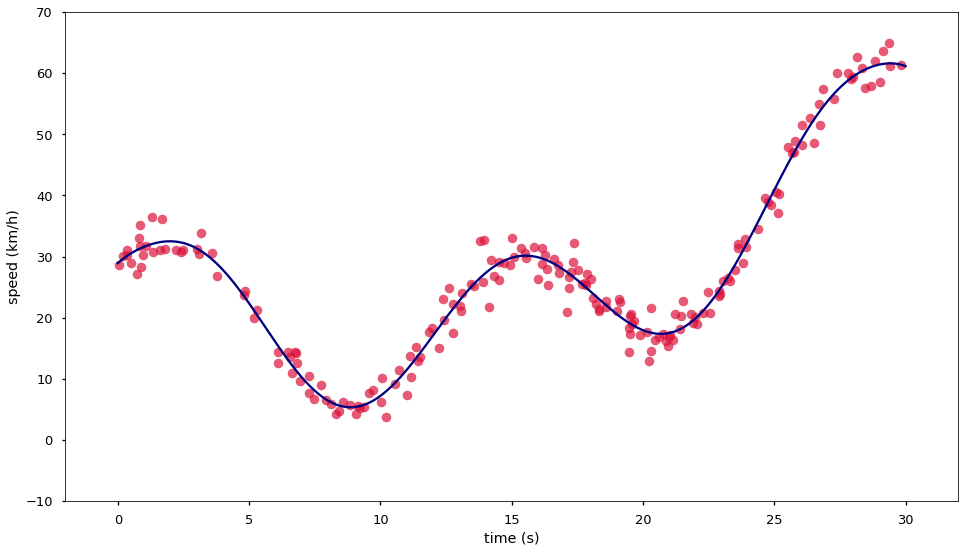

In [14]:
from sklearn.model_selection import GridSearchCV

model = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
grid = GridSearchCV(model,
                    {'polynomialfeatures__degree': list(range(5, 101))},
                    cv=5)
grid.fit(t[:, np.newaxis], spd[:, np.newaxis])
best = grid.best_estimator_
xfit = np.linspace(0, 30, 3000)
yfit = best.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70))
best, best.named_steps.linearregression.intercept_, best.named_steps.linearregression.coef_

And we should have a look at the `R2` of the best estimator we have built.

In [15]:
grid.best_score_

0.9759691071993467

Often simple *hyperparameter* tuning is enough to solve even complex problem.
Yet, the problem we saw on the left hand side was a problem of dependence between dimensions,
and sometimes it cannot be easily solved.  We shall look at more techniques.

## Regularization

The problem we see on the left hand side is that the linear regression
assumes that the **variables are independent of each other**,
yet $t^{16}$ is very dependent on $t^2$.
To reduce this dependence a few techniques exist,these build a **cost function** in which
having many coefficients that are not zero introduces a lot of error.
This is called **regularization**, for **parametric** techniques we have:

#### Ridge (often called `L2`)

$$\min_{w_1, \dots, w_{d - 1}} \|Xw_j - y\|_2^2 + \alpha\|w_j\|_2^2$$

#### Lasso (often called `L1`)

$$\min_{w_1, \dots, w_{d - 1}} \frac{1}{2\cdot N_{samples}} \|Xw_j - y\|_2^2 + \alpha\|w_j\|_1$$

#### Elastic Net

$$
\gamma\texttt{Lasso} + (1 - \gamma)\texttt{Ridge}
\space = \min_{w_1, \dots, w_{d - 1}} \frac{1}{2\cdot N_{samples}} \|Xw_j - y\|_2^2
\space + \gamma\alpha\|w_j\|_1 + \frac{1 - \gamma}{2}\alpha\|w_j\|_2^2
$$

Let's try it out.

/home/grochmal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2983.559253266536, tolerance: 400.0308029472665
  positive)


(Pipeline(memory=None,
          steps=[('polynomialfeatures',
                  PolynomialFeatures(degree=100, include_bias=True,
                                     interaction_only=False, order='C')),
                 ('lasso',
                  Lasso(alpha=10.0, copy_X=True, fit_intercept=True,
                        max_iter=300000, normalize=False, positive=False,
                        precompute=False, random_state=None, selection='cyclic',
                        tol=0.01, warm_start=False))],
          verbose=False),
 array([30.03114309]),
 array([ 0.00000000e+000, -0.00000000e+000, -7.47558593e-001,
         4.61516396e-002,  3.43912876e-003, -2.06517985e-004,
        -2.58964274e-006,  4.41503364e-008,  3.10055872e-009,
         9.43930395e-011,  1.94308948e-012,  2.08637204e-014,
        -4.71495828e-016, -4.04709189e-017, -1.73189728e-018,
        -5.90381530e-020, -1.75440878e-021, -4.64750933e-023,
        -1.08160956e-024, -2.04686864e-026, -2.10659684e-028,
      

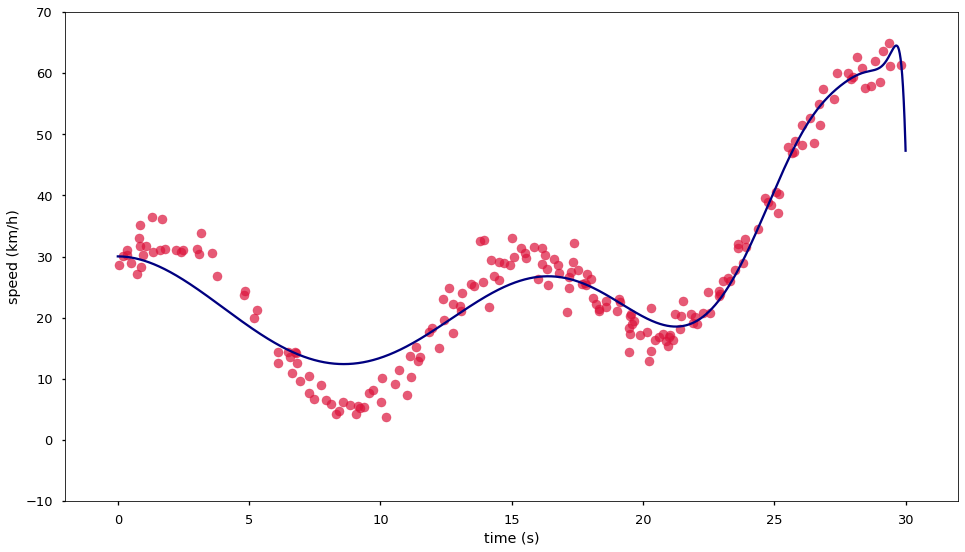

In [16]:
from sklearn.linear_model import Ridge, Lasso

#model = make_pipeline(PolynomialFeatures(degree=100), Ridge(alpha=10.0, tol=0.01, max_iter=300000))
model = make_pipeline(PolynomialFeatures(degree=100), Lasso(alpha=10.0, tol=0.01, max_iter=300000))
model.fit(t[:, np.newaxis], spd[:, np.newaxis])
xfit = np.linspace(0, 30, 3000)
yfit = model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70))
model, model.named_steps.lasso.intercept_, model.named_steps.lasso.coef_

Despite the fact that we know that a polynomial of degree 100 heavily *overfits* the data,
and, moreover, its parameters start to influence each other, we still managed to find a good fit.
This is because, thanks to the regularization, the parameters that were heavily dependent
on each other were forced to be very close to zero.

This is good but likely this is still not the best solution we can achieve.
Now we got another *hyperparameter* to tune: the *alpha* of the ridge regularization.

## Model Selection - Again

We did this before but now we have two hyperparameters to tune:
polynomial *degree* and ridge *alpha*.
The grid search uses a double underscore (`__`) to indicate a hyperparameter
(argument to model constructor).
In a pipeline the - all lowercase - name of the model, followed by the double
underscore, followed by the hyperparameter values to try;
performs the training and cross-validation across *all combinations* in the grid.

In [17]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# clear output of warnings, we will root out bad fits with crossvalidation
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

model = make_pipeline(PolynomialFeatures(degree=5), Ridge(alpha=1.0, tol=0.1, max_iter=3000))
grid = GridSearchCV(model,
                    {'polynomialfeatures__degree': list(range(5, 21)),
                     'ridge__alpha': [0.1, 0.5, 1, 2, 3, 5, 10, 20, 50, 100, 200, 300, 500]},
                    cv=5)
grid.fit(t[:, np.newaxis], spd[:, np.newaxis])
grid.best_estimator_, grid.best_score_

(Pipeline(memory=None,
          steps=[('polynomialfeatures',
                  PolynomialFeatures(degree=10, include_bias=True,
                                     interaction_only=False, order='C')),
                 ('ridge',
                  Ridge(alpha=0.1, copy_X=True, fit_intercept=True,
                        max_iter=3000, normalize=False, random_state=None,
                        solver='auto', tol=0.1))],
          verbose=False),
 0.9759664586842994)

And we have a quite good estimator.  Let's see how it plots over the data:

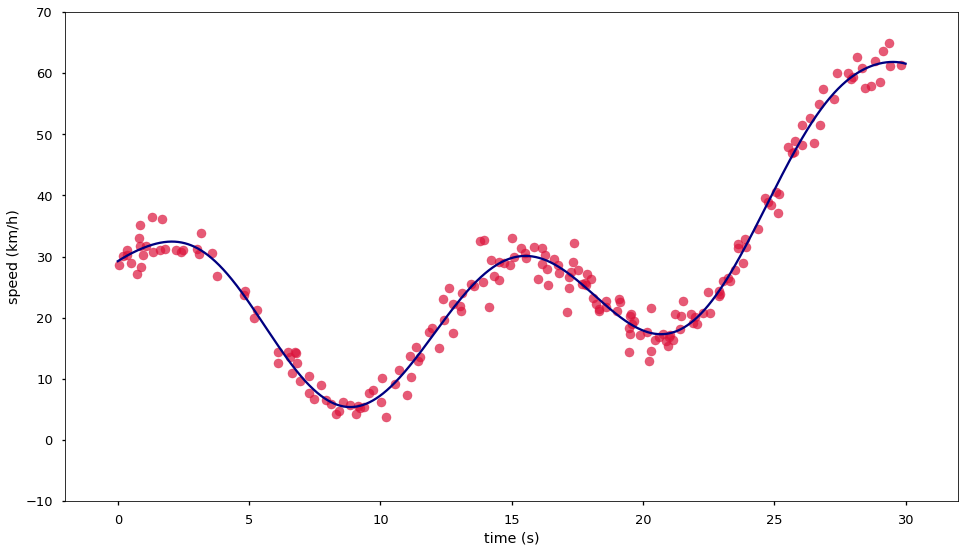

In [18]:
xfit = np.linspace(0, 30, 3000)
yfit = grid.best_estimator_.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(t, spd, color='crimson', alpha=0.7)
ax.plot(xfit, yfit, color='navy')
ax.set(xlabel='time (s)', ylabel='speed (km/h)', xlim=(-2, 32), ylim=(-10, 70));

## Take home message - Generalization

We managed to estimate a quite complex function.  But most importantly, we learned that we
have an arsenal of machine learning automation in `sklearn`, cross-validation and grid-search
are common to almost every machine learning problem, no matter the model used.

Also, we saw a model that *underfits* - has high *bias* - and a model that *overfits* - has high *variance*.
Models with either too high bias or variance will **generalize** poorly.
In other words, when we perform model selection we are searching for the model that best *generalizes*.
And we can only say that a model generalizes well to new data if we can prove that
the model does not underfit or overfit the data independently on how we test it.

Note: Just because we got the model that best generalizes across a huge grid of hyperparameters
and across a vast cross-validation, it does not mean we have the best model that we can get.
We have the model that can best generalize under the assumptions we make when building it.
For example, trying a specific ML technique is an assumption about the data.
Comparing different ML techniques on the same data means comparing the best model
(the one that best generalizes) built with each technique on this data.